In [1]:
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# Adjust display options
#pd.set_option('display.max_rows', 600)  # Display all rows
#pd.set_option('display.max_columns', None)  # Display all columns
#pd.set_option('display.width', None)  # Allow unlimited width for display

# Initialize empty list 
dfs = []
participant_ids = []

# Iterate through each CSV file in the folder
pathlist = Path("data/").rglob('*.csv')
for participant_id, path in enumerate(pathlist, start=1):
    df = pd.read_csv(path)
    dfs.append(df)
    participant_ids.extend([participant_id] * len(df))

# Concatenate all DataFrames in the list into one DataFrame
combined_df = pd.concat(dfs, ignore_index=True)
combined_df['participant_id'] = participant_ids
#print(combined_df)

# Reorder columns to place participant ID column first
cols = combined_df.columns.tolist()
cols = ['participant_id'] + [col for col in cols if col != 'participant_id']
combined_df = combined_df[cols]

# Clean data
combined_df = combined_df.dropna()
combined_df = combined_df[combined_df.rt != -1]

true_false_lst_mov = []
true_false_lst_or = []

# Iterate through each task type
for task_type in combined_df['task_type'].unique():
    # Filter the DataFrame for the current task type
    task_data = combined_df[combined_df['task_type'] == task_type]
    
    # Iterate through each participant
    for i in range(1, max(task_data['participant_id']) + 1):
        # Filter the DataFrame for the current participant and task type
        participant_data = task_data[(task_data['participant_id'] == i)]
        
        # Count the True and False answers for the current participant
        true_count = participant_data['correct'].eq(True).sum()
        false_count = participant_data['correct'].eq(False).sum()
        total_count = true_count + false_count
        
        # Calculate ratio
        if total_count > 0:
            ratio_count = true_count / total_count
        else:
            ratio_count = 0.0
        
        # Create a dictionary with the counts for the current participant and task type
        bool_dict = {
            "Participant": i,
            "Task_Type": task_type,
            "True": true_count,
            "False": false_count,
            "ratio": ratio_count
        }
        
        # Append the dictionary to respective list based on task type
        if task_type == 'mov':
            true_false_lst_mov.append(bool_dict)
        elif task_type == 'or':
            true_false_lst_or.append(bool_dict)


# Get the intersection of the two lists to find participants meeting both conditions
selected_ids_mov = [x['Participant'] for x in true_false_lst_mov if x['ratio'] >= 0.8]
selected_ids_or = [x['Participant'] for x in true_false_lst_or if x['ratio'] >= 0.8]
selected_ids = list(set(selected_ids_mov).intersection(selected_ids_or))

# Filter the combined_df based on the selected_participant_ids
filtered_df = combined_df[combined_df.participant_id.isin(selected_ids)]


# extra df for plots
df_repetition = filtered_df[filtered_df['task_transition'] == 'repetition']
df_switch = filtered_df[filtered_df['task_transition'] == 'switch']
df_or = filtered_df[filtered_df.task_type != "or"]
df_mov = filtered_df[filtered_df.task_type != "mov"]

# miliseconds to seconds
filtered_df = filtered_df.astype({'rt': 'float64'})
filtered_df.loc[:, 'rt'] = filtered_df['rt'] / 1000
filtered_df.loc[:, 'rt'] = filtered_df[filtered_df['rt'] <= 2]
filtered_df['key_press'] = filtered_df['key_press'].map({'f': 0.0, 'j': 1.0})
filtered_df['correct'] = filtered_df['correct'].map({False: 0.0, True: 1.0})
filtered_df

#filtered_df

#filtered_df['rt']


#combined_df
#for entry in true_false_lst_or:
#    print(entry)
#for entry in true_false_lst_mov:
#    print(entry)
#for entry in true_false_lst_or:
#    print(entry)
#selected_ids
#len(selected_ids)


,participant_id,rt,key_press,correct,coherent_movement_direction,coherent_orientation,task_type,task_transition,congruency
1,1,1.164,0.0,1.0,180,180,or,repetition,congruent
2,1,1.502,1.0,1.0,180,0,or,repetition,incongruent
3,1,1.155,1.0,1.0,0,0,mov,switch,congruent
4,1,0.727,1.0,1.0,0,0,mov,repetition,congruent
5,1,0.677,1.0,1.0,0,0,mov,repetition,congruent
...,...,...,...,...,...,...,...,...,...
3163,33,1.234,1.0,1.0,180,0,or,repetition,incongruent
3164,33,0.682,1.0,1.0,0,0,mov,switch,congruent
3165,33,1.667,0.0,1.0,180,0,mov,repetition,incongruent
3166,33,1.481,0.0,1.0,180,180,or,switch,congruent


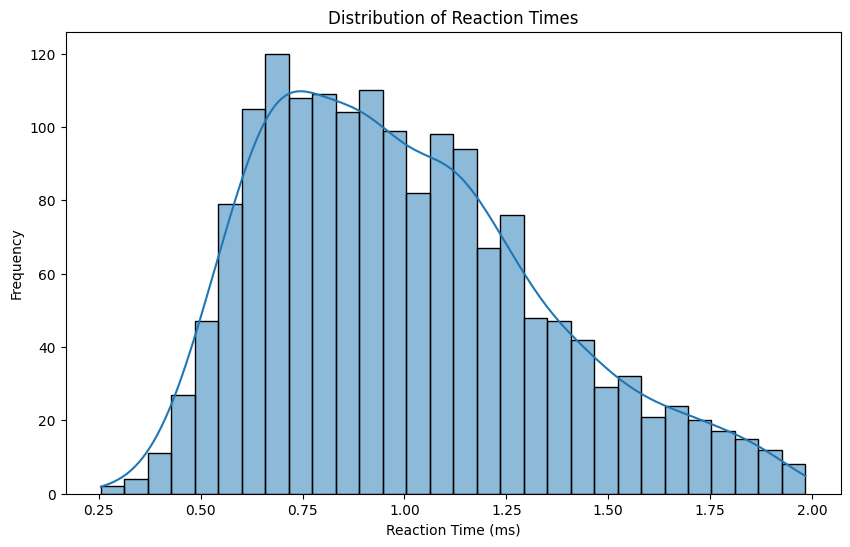

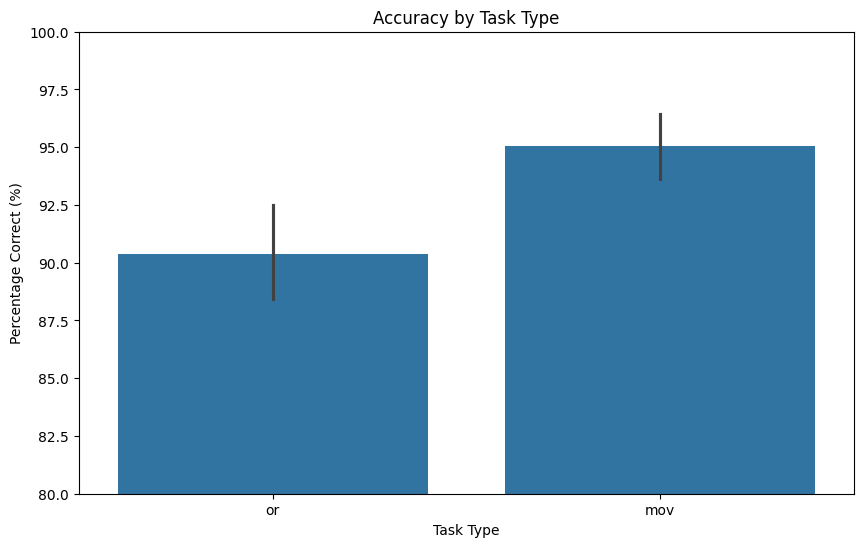

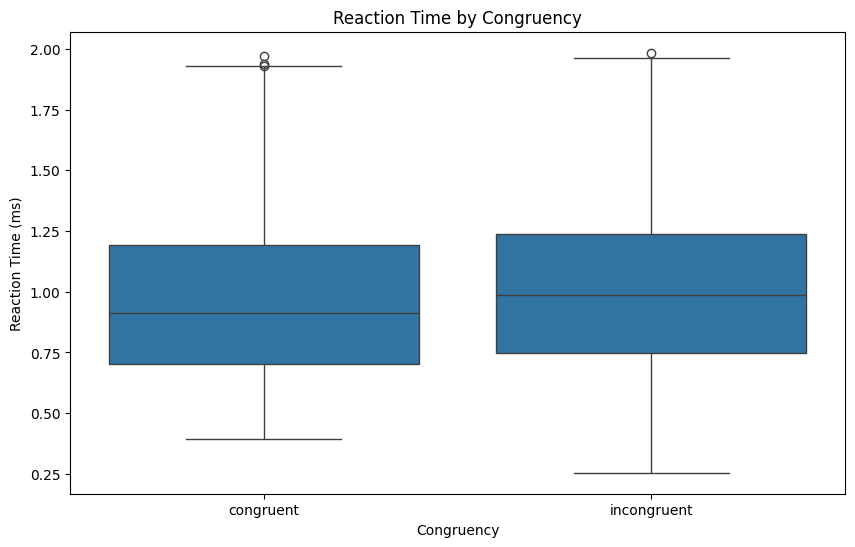

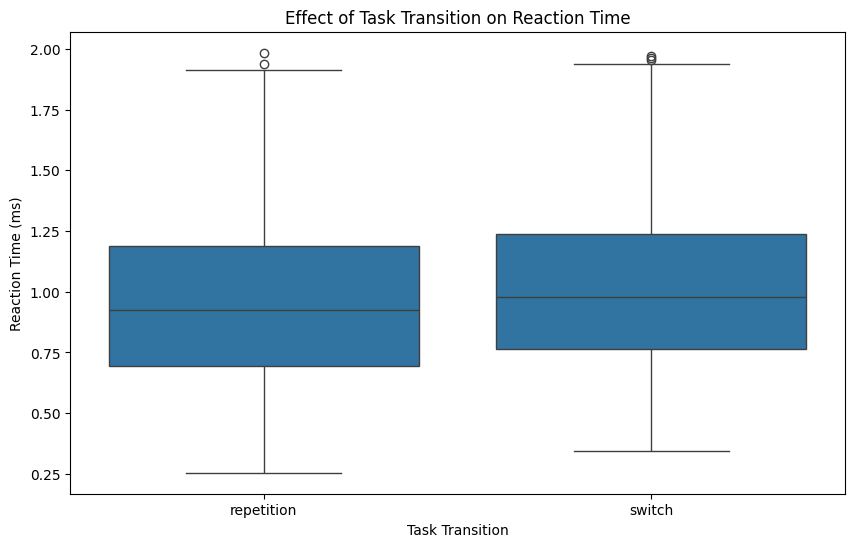

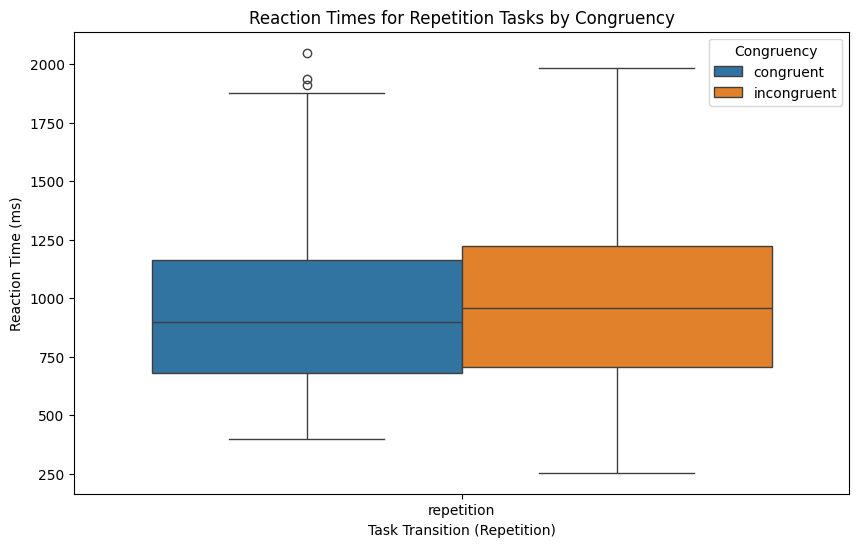

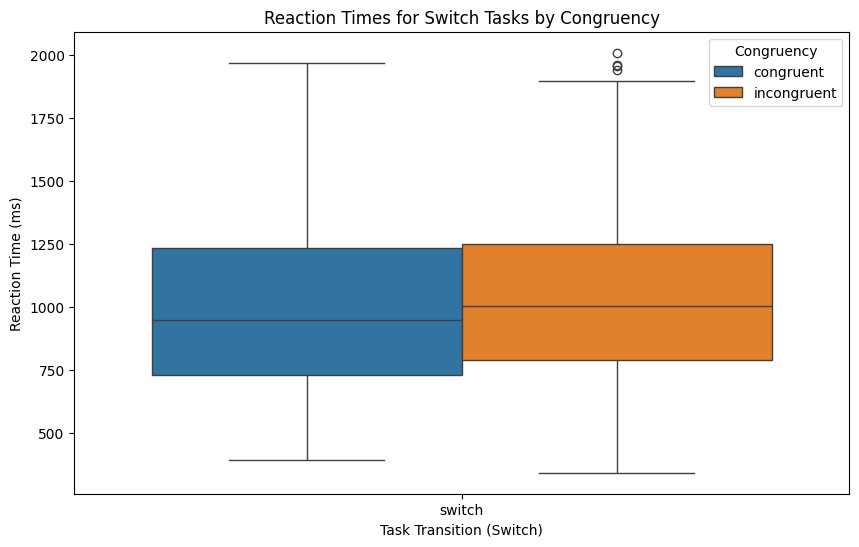

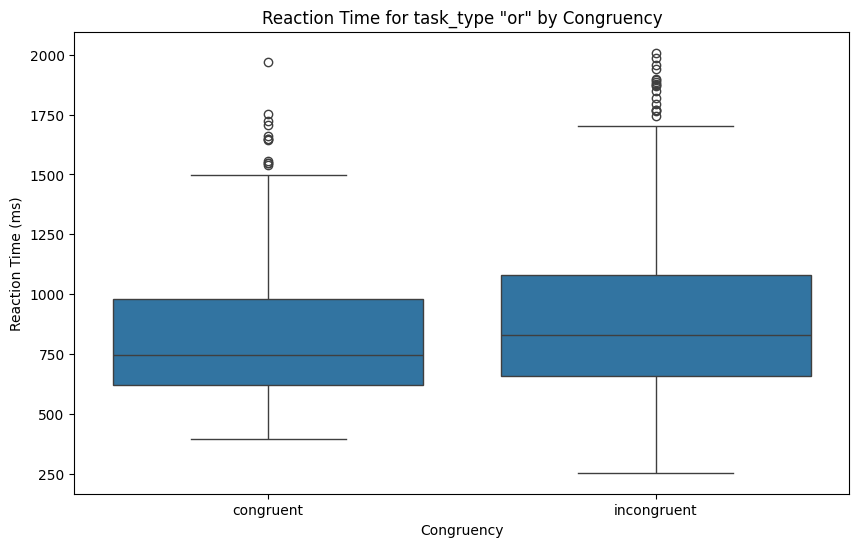

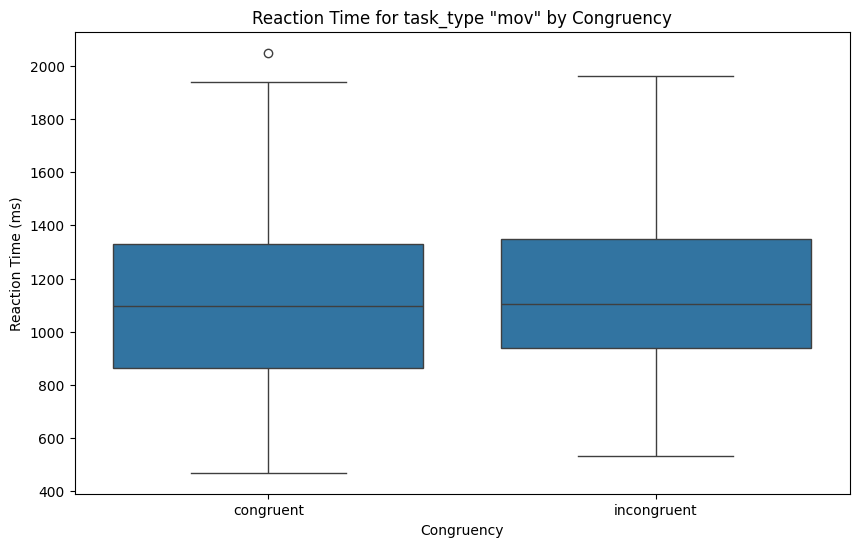

In [2]:
# Plots:
# Visualization 1: Distribution of Reaction Times
plt.figure(figsize=(10, 6))
sns.histplot(data=filtered_df, x="rt", kde=True, bins=30)
plt.title('Distribution of Reaction Times')
plt.xlabel('Reaction Time (ms)')
plt.ylabel('Frequency')
plt.show()

# Visualization 2: Accuracy by Task Type
plt.figure(figsize=(10, 6))
sns.barplot(x="task_type", y="correct", data=filtered_df, estimator=lambda x: sum(x.astype(int)) / len(x) * 100)
plt.title('Accuracy by Task Type')
plt.xlabel('Task Type')
plt.ylabel('Percentage Correct (%)')
plt.ylim(80, 100)
plt.show()

# Visualization 3: Reaction Time by Congruency
plt.figure(figsize=(10, 6))
sns.boxplot(x="congruency", y="rt", data=filtered_df)
plt.title('Reaction Time by Congruency')
plt.xlabel('Congruency')
plt.ylabel('Reaction Time (ms)')
plt.show()

# Visualization 4: Task Transition Effects on Reaction Time
plt.figure(figsize=(10, 6))
sns.boxplot(x="task_transition", y="rt", data=filtered_df)
plt.title('Effect of Task Transition on Reaction Time')
plt.xlabel('Task Transition')
plt.ylabel('Reaction Time (ms)')
plt.show()

# Visualization 5: Reaction Times for Repetition Tasks by Congruency
plt.figure(figsize=(10, 6))
sns.boxplot(x="task_transition", y="rt", hue="congruency", data=df_repetition)
plt.title('Reaction Times for Repetition Tasks by Congruency')
plt.xlabel('Task Transition (Repetition)')
plt.ylabel('Reaction Time (ms)')
plt.legend(title='Congruency')
plt.show()

# Visualization 6: Reaction Times for Switch Tasks by Congruency
plt.figure(figsize=(10, 6))
sns.boxplot(x="task_transition", y="rt", hue="congruency", data=df_switch)
plt.title('Reaction Times for Switch Tasks by Congruency')
plt.xlabel('Task Transition (Switch)')
plt.ylabel('Reaction Time (ms)')
plt.legend(title='Congruency')
plt.show()

# Visualization 7: Reaction Time for task_type "or" by Congruency
plt.figure(figsize=(10, 6))
sns.boxplot(x="congruency", y="rt", data=df_or)
plt.title('Reaction Time for task_type "or" by Congruency')
plt.xlabel('Congruency')
plt.ylabel('Reaction Time (ms)')
plt.show()

# Visualization 8: Reaction Time for task_type "mov" by Congruency
plt.figure(figsize=(10, 6))
sns.boxplot(x="congruency", y="rt", data=df_mov)
plt.title('Reaction Time for task_type "mov" by Congruency')
plt.xlabel('Congruency')
plt.ylabel('Reaction Time (ms)')
plt.show()



In [ ]:
from pyddm import Model,Sample,Fittable, Fitted
from pyddm.models import LossRobustBIC, DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, ICPointSourceCenter
from pyddm.functions import fit_adjust_model, display_model
model = Model(name='Simple model (fitted)',
                  drift=DriftConstant(drift=Fittable(minval=0, maxval=4)),
                  noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
                  bound=BoundConstant(B=Fittable(minval=.5, maxval=4)),
                  overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=0.35)),
                  dx=.001, dt=.001, T_dur=2)

# RT data must be the first column and correct/error must be the
# second column.
rt = filtered_df[:,1].copy() # Use .copy() because np returns a view
corr = filtered_df[:,3].copy()
monkey = filtered_df[:,0].copy()
filtered_df_m[:,0] = rt
M[:,1] = corr
M[:,3] = monkey
print(rt)
  
conditions = ["coh", "monkey", "trgchoice"]
roitman_sample2 = Sample.from_numpy_array(M, conditions)

fit_adjust_model(samp, model,
                 fitting_method="differential_evolution",
                 lossfunction=LossRobustBIC, verbose=False)
display_model(model)
